In [55]:
# set up environment 
include("packages.jl");

# Question 1

Refer to attached pdf.

In [56]:
# q1
include("q1.jl");

# Question 2

## 2.1

### Part a
The values are printed below. 

### Part b
Prices are definitely endogenous, so the exclusion restriction is violated, so the second moment condition may not be valid.
Relevance is also not satisifed. 
The first moment condition is part of the BLP instrument set. 
This may be relevant. 
The third moment condition is the condition for Hausman instruments. 
This one is also not obviously valid since prices could reflect demand shocks in imperfectly competitive markets.
It satisfies relevance. 


### Part c
Yes, we can use both if we believe that the Hasuman instruments are valid.




In [57]:
# q2.1 - get expected values of moment conditions
include("q2.1.jl")

## 2.2

### Part a: BLP Moments

The BLP moment condition is given by
$E[\xi_{jm} | Z_{jm}] = 0, Z = \{ X_{jm}, \sum_{i \neq j} x_{2im}, \sum_{i \neq j} x_{3im} \}$

### Part b

Fairly straightforward to construct the objective function, with identity weighting matrix. 


In [58]:
# q2.2 - get objective function

# X and Z arrays 
X = hcat(X1_jm, X2_jm, X3_jm, P_opt);
Z = (X1_jm, X2_jm, X3_jm, lo_X2_jm, lo_X3_jm);
N = length(Z);
Wt_mat = Matrix{Float64}(I, length(Z), length(Z));

# objective function
function blp_obj_fn(η);
    return η' * Wt_mat * η;
end;

### Part c

Below are the constraint functions. 
The first is the BLP moment constraint and the second is the share constraint.


In [59]:
# constraint functions
# blp moments constraint
function blp_moments(β, α, σ, δ, η);
    ξ = δ .- β[1] .* X1_jm .- β[2] .* X2_jm .- β[3] .* X3_jm .+ α .* P_opt
    moms_long = [Z_i .* ξ for Z_i in Z]
    mean_mom = [mean(mom) for mom in moms_long]
    gerr = mean_mom - η
    return gerr
end;

# shares constraint
function share_calc(β, α, σ, δ, η);
    utilities = exp.(δ .- σ .* ν_vec .* P_opt)
    choice_probs = zeros(n_products, n_markets, 100)
    choice_probs = utilities ./ (1 .+ sum(utilities, dims = 1))
    pred_share = (1/length(ν)) * sum(choice_probs, dims = 3)
    pred_share = reshape(pred_share, n_products, n_markets)
    share_diff = shares .- pred_share
    return vec(share_diff)
end;


### Part d

In [60]:

# gradient is easy for objective function
function blp_obj_fn(η)
    return η' * Wt_mat * η
end;

grad_obj = ForwardDiff.gradient(blp_obj_fn, rand(N));
grad_obj_analytical = 2 * Wt_mat * rand(N);

# i am able to use forward auto diff to give me jacobians and i didn't need to supply them for my optimisation routine anyway but lmk if i'm making a grave error :) 
# jacobian for share constraints
rand_params = vcat(rand(3), rand(1), rand(1), vec(rand(total_dim)), rand(N));
function wrapped_share_calc(params)
    β = params[1:3]      
    α = params[4]
    σ = params[5]
    δ = reshape(params[θ_size + 1:total_dim + θ_size], n_products, n_markets)
    return share_calc(β, α, σ, δ, η)
end;
jac_share_calc = ForwardDiff.jacobian(wrapped_share_calc, rand_params);

# jacobian for blp_moments
function wrapped_blp_moments(params)
    β = params[1:3]   
    α = params[4]    
    σ = params[5] 
    δ = reshape(params[θ_size + 1:total_dim + θ_size], n_products, n_markets)
    η = params[total_dim + θ_size+1:end]
    return vec(blp_moments(β, α, σ, δ, η))
end;
jac_blp_moms = ForwardDiff.jacobian(wrapped_blp_moments, rand_params);

println("jacobian for share constraints")
println(jac_share_calc)

println("jacobian for blp moments")
println(jac_blp_moms)


### Part e

I estimate $\theta$. 
I find that the estimates are not too stable across starting values. 
$\beta$ seems to be the most unstable, $\alpha$ and $\sigma$ seem alright. 
Some starting values lead to failure of convergence. I'm not sure why this happening. 
I suspect maybe I need to put some restrictions on the random generation process of initial values. 
But when it does converge, the estimates are sooo close to the truth, it's a little surprising. 
I bootstrap to get standard errors, but this is inefficient lol. Takes too much time. 
And standard errors are really high because of the failure of convergence in some cases. 


In [61]:
include("blp_fn.jl")
filename = "../data/100markets3products.mat"
include("import_data.jl")

# X and Z arrays 
X = hcat(X1_jm, X2_jm, X3_jm, P_opt)
Z = (X1_jm, X2_jm, X3_jm, lo_X2_jm, lo_X3_jm)
N = length(Z)
Wt_mat = Matrix{Float64}(I, length(Z), length(Z)) 

# try a few different starting values and see how results differ
results = []

for i in 1:5
    initial_β = rand(3)
    initial_α = rand()
    initial_σ = rand()
    initial_δ = rand(n_products, n_markets)
    initial_η = rand(N)
    push!(results, solve_blp_model(initial_β, initial_α, initial_σ, initial_δ, initial_η))
end

# get bias 
biases = []
for result in results
    β_solution = result.β_solution
    α_solution = result.α_solution
    σ_solution = result.σ_solution
    est_θ = vcat(β_solution, [α_solution], [σ_solution])
    bias = est_θ .- true_θ
    push!(biases, bias)
end
for (i, bias) in enumerate(biases)
    println("Bias for Run $i: ", bias)
end



In [62]:
# bootstrap
filename = "../data/100markets3products.mat"
include("import_data.jl")
B = 20
β_bootstrap = zeros(B, length(true_β))
α_bootstrap = zeros(B)
σ_bootstrap = zeros(B)

for b in 1:B
    # Resample indices with replacement
    resample_idx = rand(1:n_markets, n_markets)
    X1_jm_bs, X2_jm_bs, X3_jm_bs, lo_X2_jm_bs, lo_X3_jm_bs = X1_jm[:, resample_idx], X2_jm[:, resample_idx], X3_jm[:, resample_idx], lo_X2_jm[:, resample_idx], lo_X3_jm[:, resample_idx]
    Z_bs = (X1_jm_bs, X2_jm_bs, X3_jm_bs, lo_X2_jm_bs, lo_X3_jm_bs);
    P_opt_bs = P_opt[:,resample_idx]

    function blp_moments_bs(β, α, σ, δ, η)   
        ξ = δ .- β[1] .* X1_jm_bs .- β[2] .* X2_jm_bs .- β[3] .* X3_jm_bs .+ α .* P_opt_bs
        moms_long = [Z_i .* ξ for Z_i in Z_bs]
        mean_mom = [mean(mom) for mom in moms_long]
        gerr = mean_mom - η
        return gerr
    end
    
    # shares constraint
    function share_calc_bs(β, α, σ, δ, η)
        utilities = exp.(δ .- σ .* ν_vec .* P_opt_bs)
        choice_probs = zeros(n_products, n_markets, 100)
        choice_probs = utilities ./ (1 .+ sum(utilities, dims = 1))
        pred_share = (1/length(ν)) * sum(choice_probs, dims = 3)
        pred_share = reshape(pred_share, n_products, n_markets)
        share_diff = shares .- pred_share
        return vec(share_diff)
    end

    model_bs = Model(Ipopt.Optimizer)

    # define variables with initial values
    @variable(model_bs, 0.0 <= η[1:N] <= 1.0)
    @variable(model_bs, δ[1:n_products, 1:n_markets])
    @variable(model_bs, 0.0 <= α <= 1.0)
    @variable(model_bs, β[1:3] >= 0.0)
    @variable(model_bs, σ >= 0.0)

    @objective(model_bs, Min, sum(η[i] * Wt_mat[i, j] * η[j] for i in 1:N, j in 1:N))
    @constraint(model_bs, [j=1:N], blp_moments_bs(β, α, σ, δ, η)[j] == 0)
    @constraint(model_bs, [j=1:total_dim], share_calc_bs(β, α, σ, δ, η)[j] == 0)
    optimize!(model_bs);
    
    # Store bootstrap estimates
    β_bootstrap[b, :] =  value.(β)
    α_bootstrap[b] = value(α)
    σ_bootstrap[b] = value(σ)
end


In [63]:
# Calculate standard errors
β_se = std(β_bootstrap, dims=1)
α_se = std(α_bootstrap)
σ_se = std(σ_bootstrap)

println("Standard errors for β: ", β_se)
println("Standard errors for α: ", α_se)
println("Standard errors for σ: ", σ_se)

In [64]:
# 1 round of estimation to get estimates
include("blp_fn.jl")

filename = "../data/100markets3products.mat"
include("import_data.jl")

# X and Z arrays 
X = hcat(X1_jm, X2_jm, X3_jm, P_opt)
Z = (X1_jm, X2_jm, X3_jm, lo_X2_jm, lo_X3_jm)
N = length(Z)
Wt_mat = Matrix{Float64}(I, length(Z), length(Z)) 

estimates = solve_blp_model(rand(3), rand(), rand(), rand(n_products, n_markets), rand(N))
β_hat = estimates.β_solution
α_hat = estimates.α_solution
σ_hat = estimates.σ_solution

println("Estimated β: ", β_hat)
println("Estimated α: ", α_hat)
println("Estimated σ: ", σ_hat)

### Part f
See below. 

In [65]:
# pick one of the estimates
result = results[1]
β_hat = result.β_solution
α_hat = result.α_solution
σ_hat = result.σ_solution
δ_hat = result.δ_solution
η_hat = result.η_solution

filename = "../data/100markets3products.mat";
include("import_data.jl");


In [66]:
# price elasticity of demand 
params = vcat(β_hat, α_hat, σ_hat, vec(δ_hat), η_hat)
est_shares = shares - reshape(share_calc(β_hat, α_hat, σ_hat, δ_hat, η_hat), 3, 100)

function share_calc_derivative(δ_vec)
    eutilities = exp.(reshape(δ_vec, n_products, n_markets) .- σ_hat .* ν_vec .* P_opt)
    choice_probs = zeros(3, 100, 100)
    choice_probs = eutilities ./ (1 .+ sum(eutilities, dims = 1))
    pred_share = (1/length(ν)) * sum(choice_probs, dims = 3)
    pred_share = reshape(pred_share, 3, 100)
    return vec(pred_share)
end
δ_hat_vec = vec(δ_hat)
jac_share_calc = ForwardDiff.jacobian(share_calc_derivative, δ_hat_vec)

est_pe = vec(P_opt ./ est_shares) .* diag(jac_share_calc) .* α_hat 

# print results
println("Price Elasticity of Demand Estimates: ", est_pe)


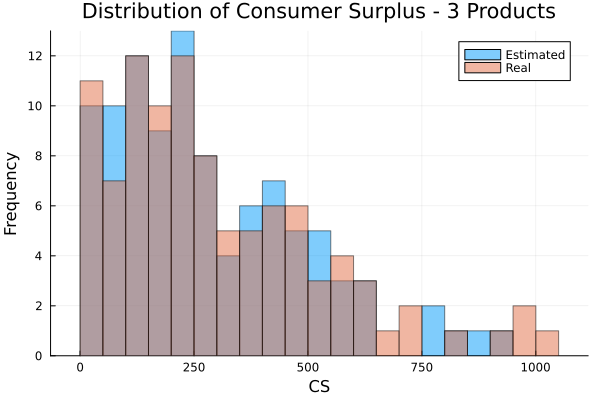

In [67]:
# consumer surplus
α_i_hat = α_hat .+ σ_hat .* ν
α_i_hat = reshape(α_i_hat, 1, 1, 100)
est_u_ijm = β_hat[1] .* X1_jm .+ β_hat[2] .* X2_jm .+ β_hat[3] .* X3_jm .- α_i_hat .* P_opt .+ ξ_jm
est_u_ijm = max.(est_u_ijm, 0.0)
est_cs = reshape(sum(est_u_ijm, dims = 3), 3, 100)
est_cs = sum(est_cs, dims = 1)

# true parameter consumer surplus 
u_ijm = true_β[1] .* X1_jm .+ true_β[2] .* X2_jm .+ true_β[3] .* X3_jm .- α_i .* P_opt .+ ξ_jm
u_ijm = max.(u_ijm, 0.0)
cs_jm = reshape(sum(u_ijm, dims = 3), n_products, n_markets)
cs_m = sum(cs_jm, dims = 1)

histogram(est_cs[:], bins = 20, label="Estimated", alpha=0.5, normalize=false)
histogram!(cs_m[:], bins = 20, label="Real", alpha=0.5, normalize=false)
xlabel!("CS")
ylabel!("Frequency")
title!("Distribution of Consumer Surplus - 3 Products")



In [68]:
# profits
# marginal cost - dimension j x m
mc_jm = zeros(size(Z))
mc_jm = true_γ[1] .* ones(size(mc_jm)) .+ true_γ[2] .* W .+ true_γ[3] .* Z .+ η

# profits - dimension j x m
π_jm = zeros(size(Z))
π_jm = (P_opt  .- mc_jm) .* shares

# estimated profits
est_π_jm = (P_opt  .- mc_jm) .* est_shares
est_π_jm - π_jm

3×100 Matrix{Float64}:
 4.86272e-6   0.00383435   0.00921094  …  0.000853925   0.00116872
 0.0240498   -0.00148335   0.00654251     0.0163391     0.00697537
 0.00319995  -0.0250026   -0.0220836      0.0124205    -0.0103749

### Part g

Repeating estimation for 3 products, 10 markets. 
The estimates are worse, relative to the case with 100 markets. Faster though!

In [69]:
# repeat for M = 10 
filename = "../data/10markets3products.mat"
include("import_data.jl")
include("blp_fn.jl")

# construct leave out X's
lo_X2_jm = repeat(sum(X2_jm, dims = 1), inner=(size(X2_jm, 1), 1)).- X2_jm
lo_X3_jm = repeat(sum(X3_jm, dims = 1), inner=(size(X3_jm, 1), 1)) .- X3_jm

W_vector = W_j .* ones(n_products,n_markets)

# X and Z arrays 
X = hcat(X1_jm, X2_jm, X3_jm, P_opt)
Z = (X1_jm, X2_jm, X3_jm, lo_X2_jm, lo_X3_jm)

N = length(Z)
W = Matrix{Float64}(I, length(Z), length(Z)) 

# estimate the model
results_10m = []
for i in 1:5
    initial_β = rand(3)
    initial_α = rand()
    initial_σ = rand()
    initial_δ = rand(n_products, n_markets)
    initial_η = rand(N)
    push!(results_10m, solve_blp_model(initial_β, initial_α, initial_σ, initial_δ, initial_η))
end

# get bias 
biases_10m = []
for result in results_10m
    β_solution = result.β_solution
    α_solution = result.α_solution
    σ_solution = result.σ_solution
    est_θ = vcat(β_solution, [α_solution], [σ_solution])
    bias = est_θ .- true_θ
    push!(biases_10m, bias)
end
for (i, bias) in enumerate(biases_10m)
    println("Bias for Run $i: ", bias)
end

# 1 round of estimation to get estimates
estimates = solve_blp_model(rand(3), rand(), rand(), rand(n_products, n_markets), rand(N))
β_hat = estimates.β_solution
α_hat = estimates.α_solution
σ_hat = estimates.σ_solution

println("Estimated β: ", β_hat)
println("Estimated α: ", α_hat)
println("Estimated σ: ", σ_hat)

## 2.3

Incorrectly assume that prices are exogenous too. 
I take this question to mean that we can include price in the instrument set and rerun BLP. 
Honestly it doesn't make it that much worse, even though we know prices are endogenous here.
But estimates are a little further from the truth. 


In [70]:
# purpose: blp estimation with price included in instrument set
# author: vaidehi

include("blp_fn.jl")

# import data for 3 products
true_β = [5,1,1];
true_γ = [2,1,1];
true_α = 1;
true_σ_α = 1;
true_θ = [true_β; true_α; true_σ_α]
θ_size = length(true_θ);

filename = "../data/100markets3products.mat"
include("import_data.jl")

# X and Z arrays 
X = hcat(X1_jm, X2_jm, X3_jm, P_opt)
Z = (X1_jm, X2_jm, X3_jm, lo_X2_jm, lo_X3_jm, P_opt)
N = length(Z)
Wt_mat = Matrix{Float64}(I, length(Z), length(Z)) 

# constraint functions
# blp moments constraint
function blp_moments(β, α, σ, δ, η)   
    ξ = δ .- β[1] .* X1_jm .- β[2] .* X2_jm .- β[3] .* X3_jm .+ α .* P_opt
    moms_long = [Z_i .* ξ for Z_i in Z]
    mean_mom = [mean(mom) for mom in moms_long]
    gerr = mean_mom - η
    return gerr
end

# shares constraint
function share_calc(β, α, σ, δ, η)
    utilities = exp.(δ .- σ .* ν_vec .* P_opt)
    choice_probs = zeros(n_products, n_markets, 100)
    choice_probs = utilities ./ (1 .+ sum(utilities, dims = 1))
    pred_share = (1/length(ν)) * sum(choice_probs, dims = 3)
    pred_share = reshape(pred_share, n_products, n_markets)
    share_diff = shares .- pred_share
    return vec(share_diff)
end

# try a few different starting values and see how results differ
results_wp = []

for i in 1:5
    initial_β = rand(3)
    initial_α = rand()
    initial_σ = rand()
    initial_δ = rand(n_products, n_markets)
    initial_η = rand(N)
    push!(results_wp, solve_blp_model(initial_β, initial_α, initial_σ, initial_δ, initial_η))
end

# get bias 
biases_wp = []
for result in results_wp
    β_solution = result.β_solution
    α_solution = result.α_solution
    σ_solution = result.σ_solution
    est_θ = vcat(β_solution, [α_solution], [σ_solution])
    bias = est_θ .- true_θ
    push!(biases_wp, bias)
end
for (i, bias) in enumerate(biases_wp)
    println("Bias for Run $i: ", bias)
end

biases_wp .- biases

5-element Vector{Vector{Float64}}:
 [0.37039216428442057, 0.17322353194595264, 0.04440473853874238, 0.27402159812852545, 0.08087851917777433]
 [0.37109633976186274, 0.17340889386263292, 0.04447054397412109, 0.2741753192021046, 0.08097098523567137]
 [-6.9610543697627, 0.4519774258835989, -1.9453827715307856, 0.6090195926600858, -2.5739811492443487]
 [0.3704742861241508, 0.17336161955178653, 0.04443573798452305, 0.27405417948964217, 0.08089406828845225]
 [-21.76685317312445, -8.312098108883918, -6.64255274414305, 0.7290060394243132, -7.2755190154027405]

# Question 3 

## Part 1

### (a)
The moment condition is given by
$E[\xi_{jm} | Z_{jm}] = 0, Z = \{ X_{jm}, \sum_{i \neq j} x_{2im}, \sum_{i \neq j} x_{3im}, W_j \}$, where $W_j$ is the cost-shifter. 


### (b)
Using $W_j$ as an instrument significantly improves speed of optimisation and also brings estimates closer to the true values. 
The estimates are very stable across different initial values which is promising. 

In [71]:
filename = "../data/100markets3products.mat";
include("q3.1.b.jl");
println("Estimated β: ", β_hat)
println("Estimated α: ", α_hat)
println("Estimated σ: ", σ_hat)

In [72]:
# price elasticity of demand 
filename = "../data/100markets3products.mat";
include("q3.1.b.jl");
params = vcat(β_hat, α_hat, σ_hat, vec(δ_hat), η_hat)
est_shares = shares - reshape(share_calc(β_hat, α_hat, σ_hat, δ_hat, η_hat), 3, 100)
δ_hat_vec = vec(δ_hat)
jac_share_calc = ForwardDiff.jacobian(share_calc_derivative, δ_hat_vec)

est_pe = vec(P_opt ./ est_shares) .* diag(jac_share_calc) .* α_hat 

# print results
println("Price Elasticity of Demand Estimates: ", est_pe)

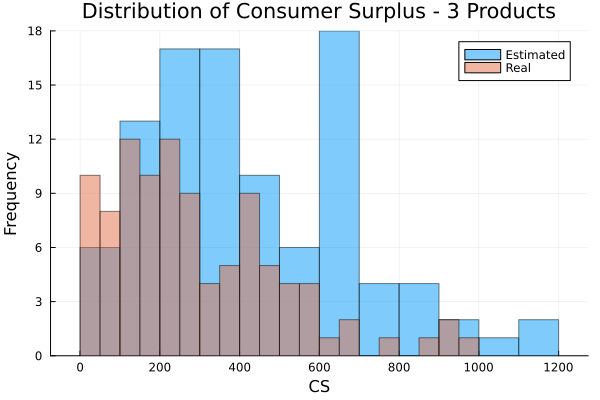

In [73]:
# consumer surplus:
est_u_ijm = β_hat[1] .* X1_jm .+ β_hat[2] .* X2_jm .+ β_hat[3] .* X3_jm .- α_i_hat .* P_opt .+ ξ_jm
est_u_ijm = max.(est_u_ijm, 0.0)
est_cs = reshape(sum(est_u_ijm, dims = 3), 3, 100)
est_cs = sum(est_cs, dims = 1)
histogram(est_cs[:], bins = 20, label="Estimated", alpha=0.5, normalize=false)
histogram!(cs_m[:], bins = 20, label="Real", alpha=0.5, normalize=false)
xlabel!("CS")
ylabel!("Frequency")
title!("Distribution of Consumer Surplus - 3 Products")


In [74]:
# profits
est_π_jm = (P_opt  .- mc_jm) .* est_shares
est_π_jm - π_jm

3×100 Matrix{Float64}:
  8.83767e-16   6.93431e-13   1.04253e-12  …   6.65561e-14   4.79443e-14
 -1.84186e-12  -1.53044e-13   6.47996e-13      5.84532e-13   4.1056e-13
  3.66651e-14  -2.33102e-12  -1.68476e-12     -3.02536e-13  -1.17439e-12

### (c)
10 Markets - these estimates look pretty bad and very far from the true values. 

In [75]:
filename = "../data/10markets3products.mat"
include("q3.1.b.jl")
println("Estimated β: ", β_hat)
println("Estimated α: ", α_hat)
println("Estimated σ: ", σ_hat)
println(results_w)